# A Great Jupyter Notebook

## Palmer Penguins

Let's take a gander at the penguins dataset:

In [1]:
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
# pd.options.mode.chained_assignment = None

penguins_df = load_penguins()
penguins_cleaned_df = penguins_df.dropna()
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Let's clean and visualise our variables of interest:

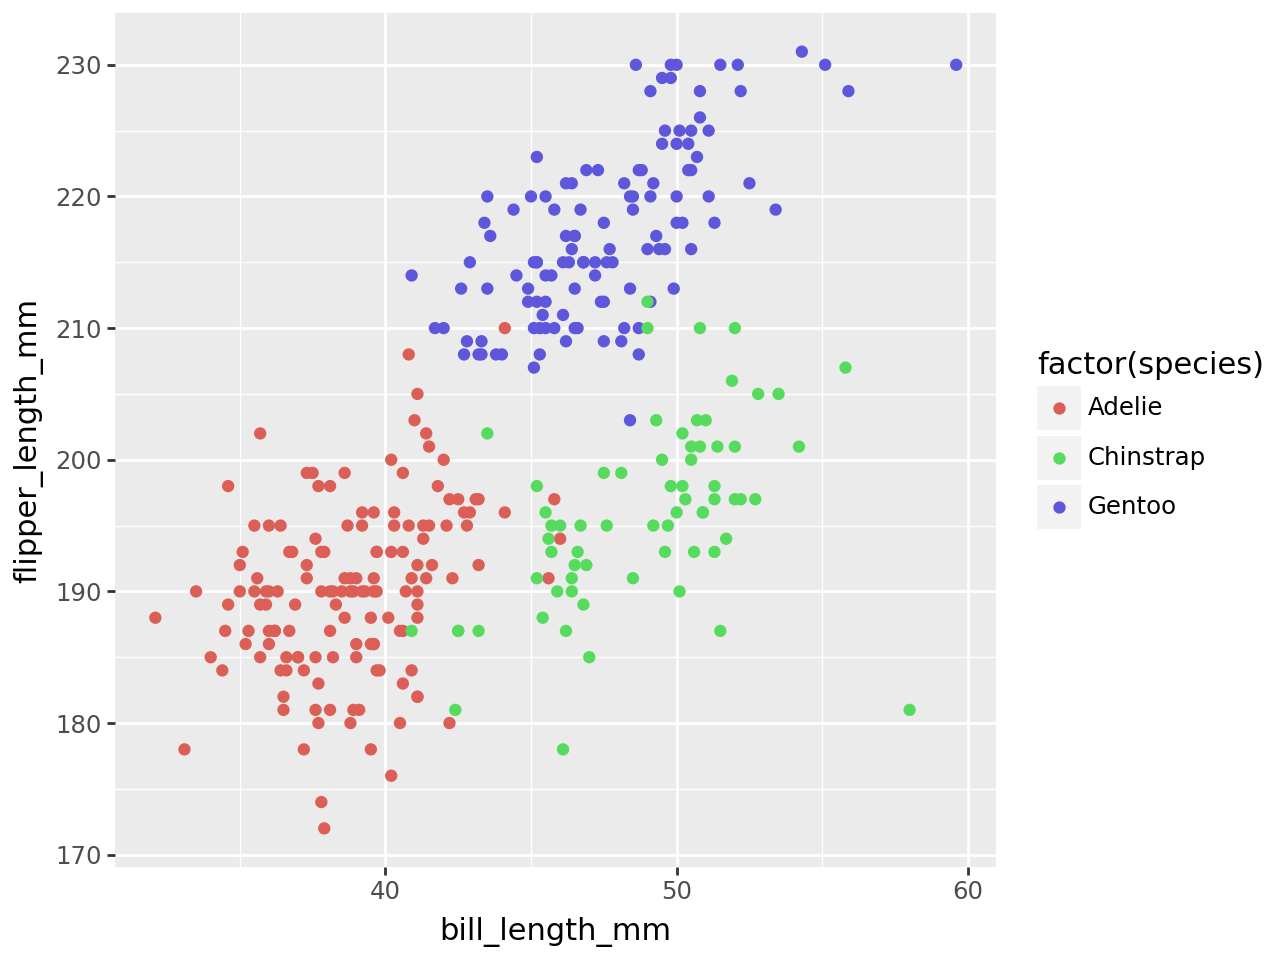

In [2]:
import plotnine as pn

# Drop rows with missing values

(
    pn.ggplot(penguins_cleaned_df, pn.aes("bill_length_mm",
           "flipper_length_mm", color="factor(species)"))
    + pn.geom_point()
)

### KMeans clustering

Let's see if these two variables are sufficient to identify penguin species with KMeans.

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

selected_features = ["bill_length_mm", "flipper_length_mm"]

model_params = {"n_clusters": 3,
                "max_iter": 300}

penguins_data_df = penguins_cleaned_df.copy()

features_df = penguins_data_df.loc[:, selected_features]

# kmeans needs scaled features
standard_scalar = StandardScaler()
features_standard_scalar = standard_scalar.fit_transform(features_df)

kmeans_model = KMeans(
    n_clusters=model_params["n_clusters"], max_iter=model_params["max_iter"])

penguin_predictions = kmeans_model.fit_predict(features_standard_scalar)
penguins_data_df.loc[:, "cluster"] = penguin_predictions

Let's match up the clusters to the species by the cluster containing most predictions

In [5]:
cluster_species = penguins_data_df.groupby(
    "species")["cluster"].agg(lambda x: x.value_counts().index[0])

cluster_species_df = cluster_species.reset_index()

penguins_data_df['cluster'] = penguins_data_df['cluster'].astype(str)
cluster_species_df['cluster'] = cluster_species_df['cluster'].astype(str)

penguins_data_df.loc[:, "cluster"] = penguins_data_df["cluster"].map(
    cluster_species_df.set_index("cluster")["species"])

Let's now visualise how well the clustering worked:

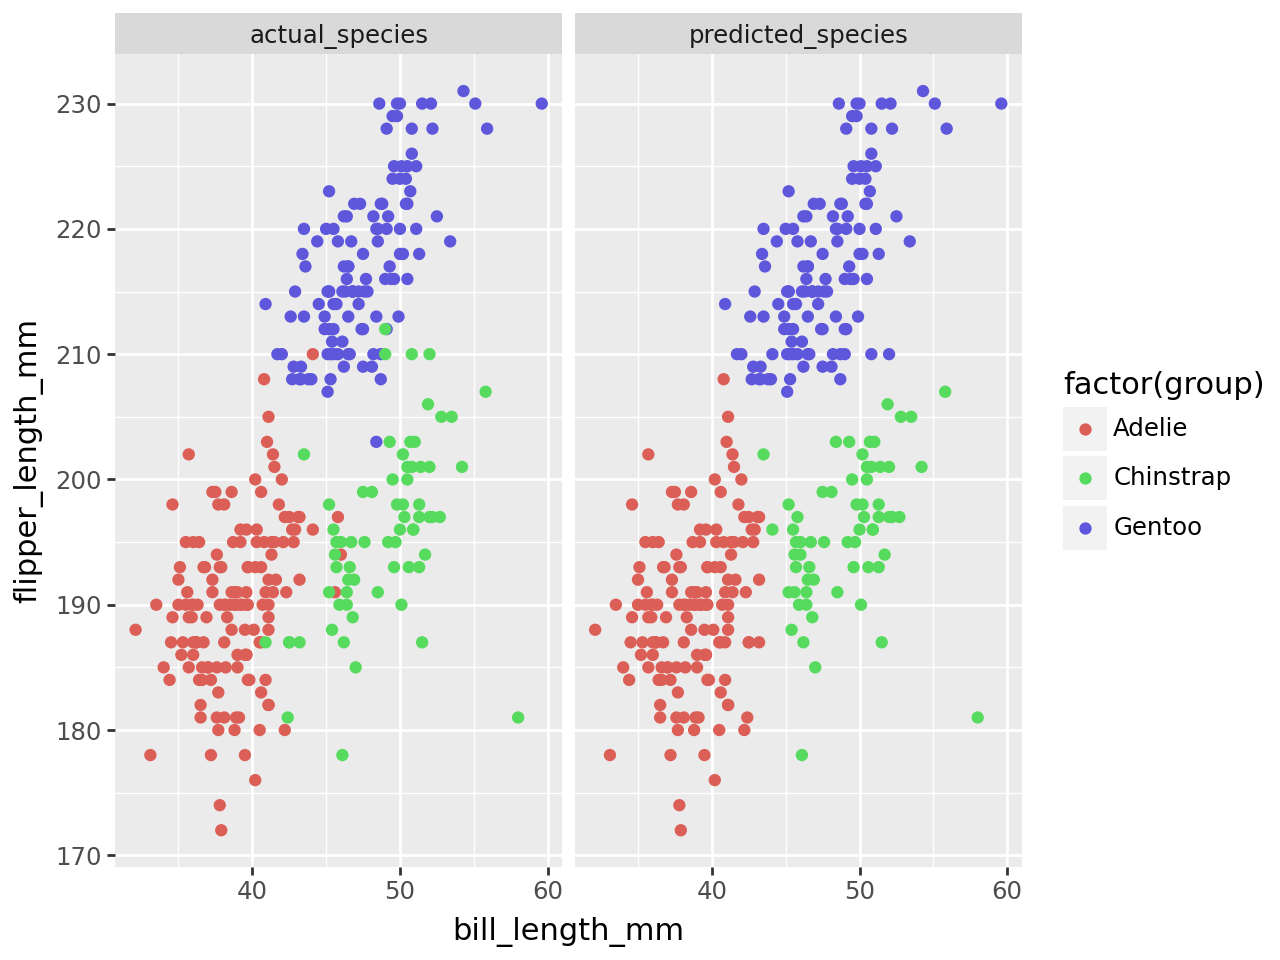

In [ ]:
import plotnine as pn

cols_compare = ["species",
                "cluster", "bill_length_mm", "flipper_length_mm"]
penguins_selected = penguins_data_df[cols_compare]

penguins_selected = penguins_selected.rename(columns={
    "species": "actual_species", "cluster": "predicted_species"})

penguins_clust_long = pd.melt(penguins_selected,
                              id_vars=["bill_length_mm", "flipper_length_mm"],
                              var_name="measure",
                              value_name="group")

(
    pn.ggplot(penguins_clust_long, pn.aes("bill_length_mm",
                                          "flipper_length_mm", color="factor(group)"))
    + pn.geom_point()
    + pn.facet_wrap("measure")
)